In [16]:
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import re
import numpy as np



#open CSV
filename = 'mieszkania.csv'
f = open(filename, "w")

headers = "lp, price, localization, size\n"

my_url = 'https://www.gumtree.pl/s-mieszkania-i-domy-sprzedam-i-kupie/warszawa/v1c9073l3200008p1?pr=200000,500000'


uClient = uReq(my_url)
page_html = uClient.read()
uClient.close()
page_soup = soup(page_html,"html.parser")

summary = page_soup.findAll("div",{"class":"breadcrumbs"})

#price filters
filter1 = re.search('=\d*',summary[0].findAll("a",{"class":"category"})[1]["href"])
bottom_price = filter1[0][1:]

filter2 = re.search('\d,\d*',summary[0].findAll("a",{"class":"category"})[1]["href"])
top_price = filter2[0][2:]

#number of postings
number_of_postings = summary[0].findAll("span",{"class":"count"})[0].text.strip()
number_of_postings_thousands = int(number_of_postings[20:22])
number_of_postings_rest = int(number_of_postings[23:])
number_of_postings_int = number_of_postings_thousands*1000 + number_of_postings_rest

#write CSV summary
f.write("Cena od "+bottom_price+" do "+top_price + "\n")
f.write("Liczba ogłoszeń: "+"\n")
f.write(str(number_of_postings_int)+"\n")
f.write(headers)





#how many pages to loop through
pages = number_of_postings_int//20

count = 0
for page in np.arange(1,30,1):
    my_url ='https://www.gumtree.pl/s-mieszkania-i-domy-sprzedam-i-kupie/warszawa/page-'+str(page)+'/v1c9073l3200008p'+str(page)+'?pr=200000,500000'
    uClient = uReq(my_url)
    page_html = uClient.read()
    
    page_soup = soup(page_html,"html.parser")
    
        


    #postings container
    containers = page_soup.findAll("div",{"class":"container"})

  
    for container in range(0,len(containers)):
    
        count += 1
    
        price = containers[container].findAll("span",{"class":"amount"})[0].text.replace('\xa0','').replace(' zł','')
    
    #localization
    
        localization_dirty = containers[container].findAll("div",{"class":"category-location"})[0].text.strip()
    
        localization_clean = re.search(',.*',localization_dirty)[0][2:]
    
        description_hidden = containers[container].findAll("div",{"class":"description hidden"})[0].text.strip()
        
        
    #size
        size_dirty = re.search('(\d\d+.m2|\d\d+m2|\d\d,\d+.m2|\d\d,\d+m2)',description_hidden)

        if size_dirty != None:
    
            size = size_dirty[0].replace('m2','').replace(' ','').replace(',','.') 
        else:
            
            link = containers[2].findAll("a",{"class":"href-link"})[0].text.strip()
            regex = re.search('(\d\d+.m2|\d\d+m2|\d\d,\d+.m2|\d\d,\d+m2)',link)
            size = (regex[0].replace('m2','').replace(' ','').replace(',','.') if regex != None else "None")
    
      
    
    #add to CSV
        f.write(str(count) + "," + str(price) + "," + localization_clean + "," + str(size) + "," + "\n")
    

uClient.close()    
f.close()

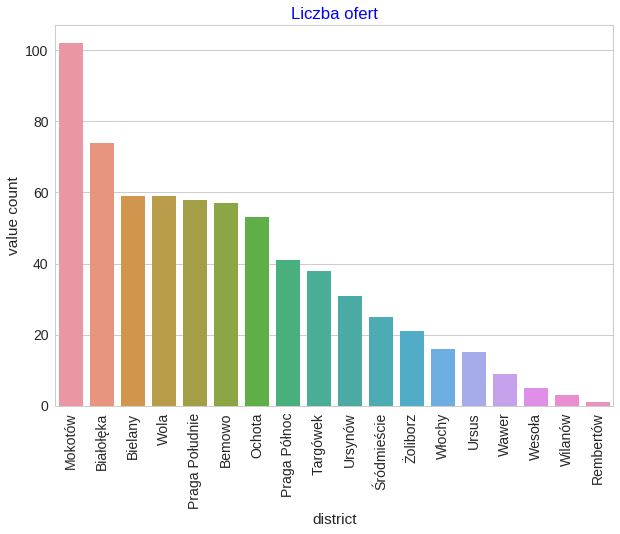

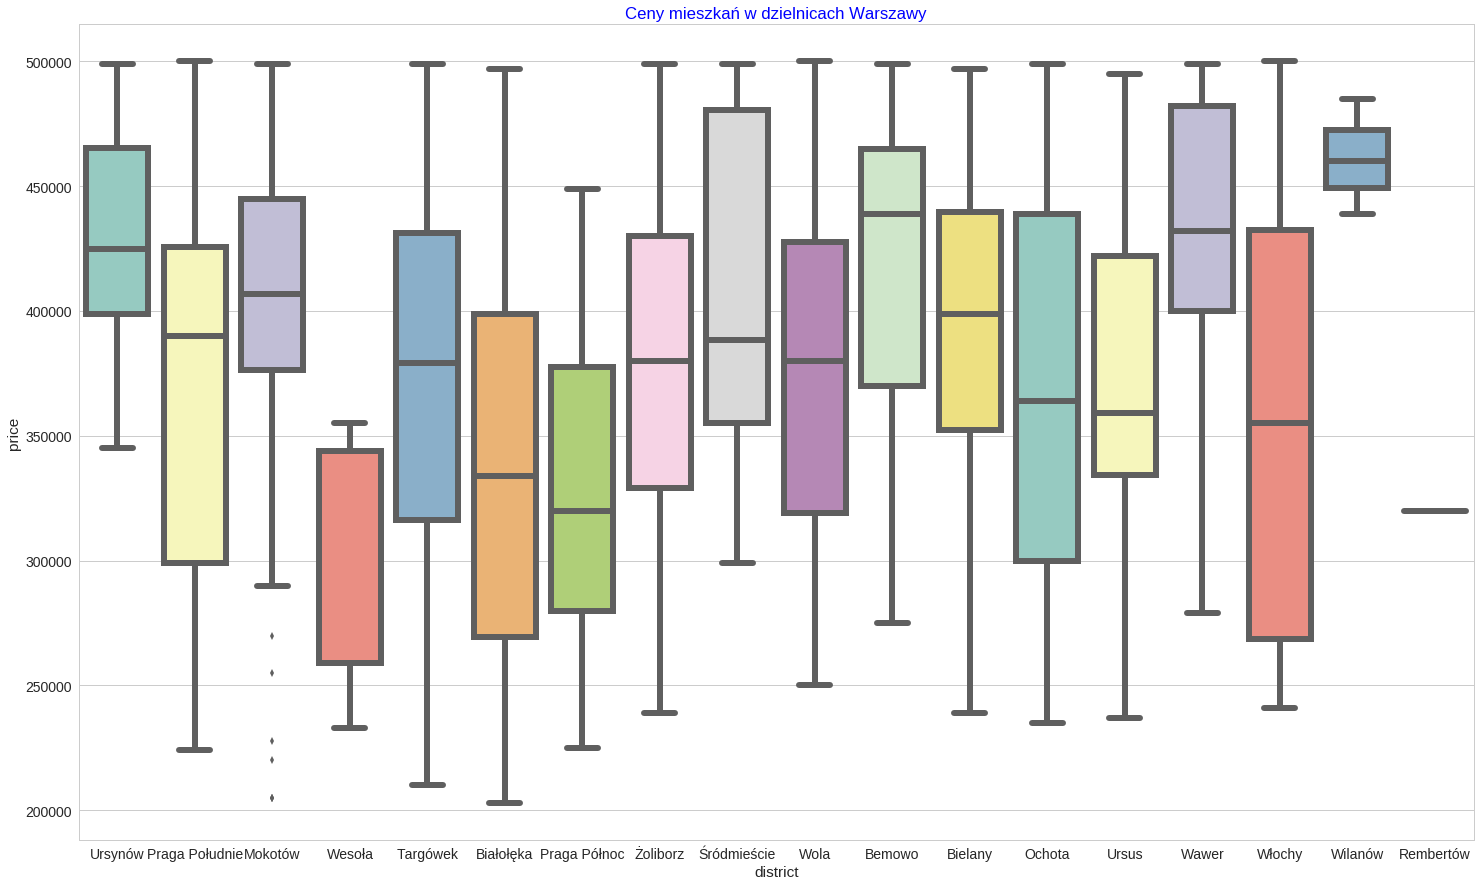

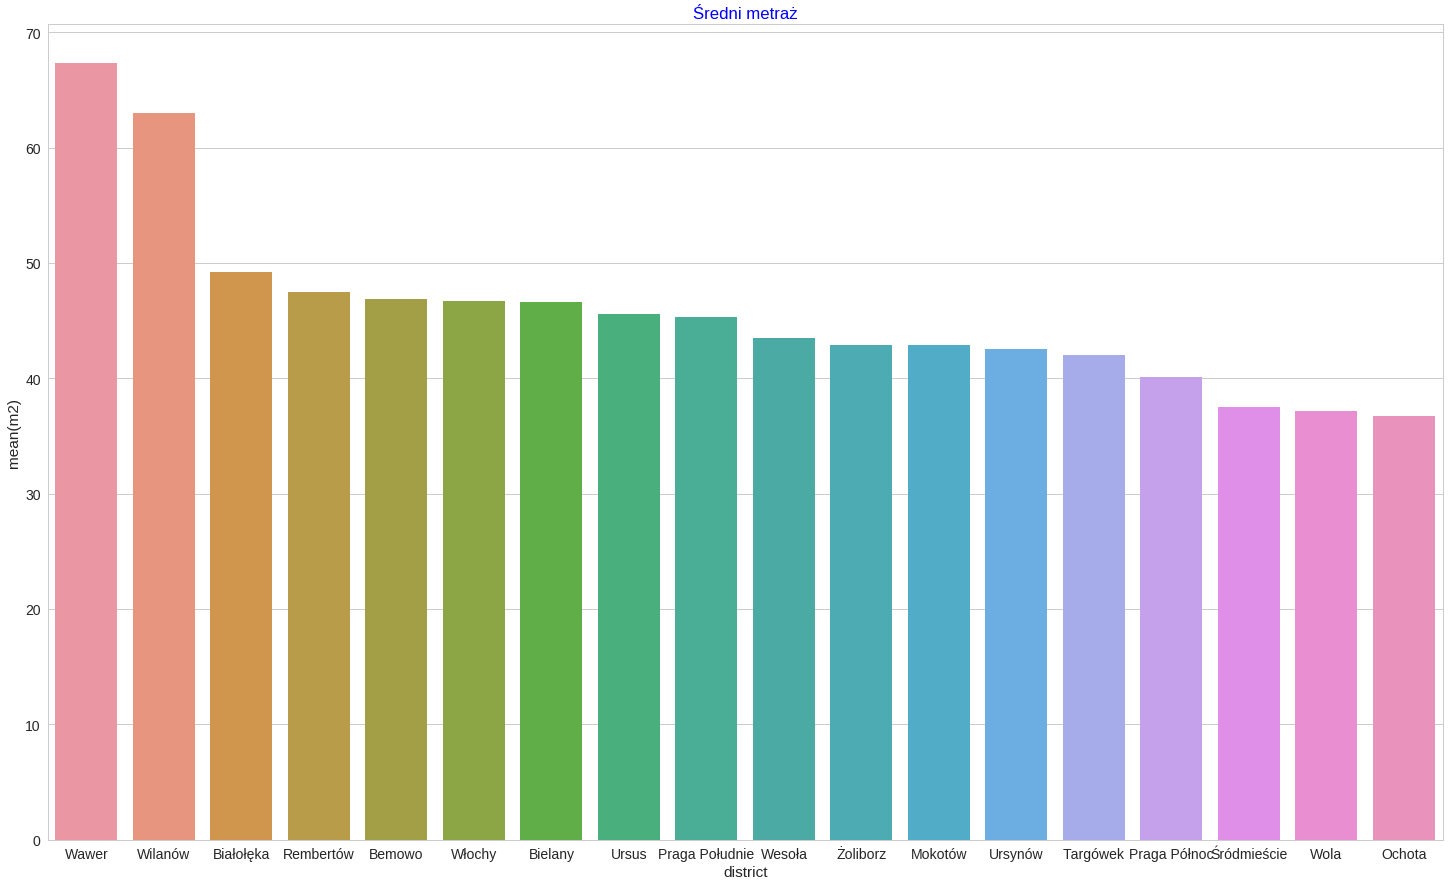

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mieszkania = pd.read_csv('mieszkania.csv',delimiter=',',skiprows=4,header=None, index_col=0, names = ["price","district",'m2','x'])
mieszkania.drop(["x"],axis=1,inplace=True)

mieszkania.m2 = mieszkania.m2.apply(lambda x: x.replace('None','nan'))
mieszkania.m2 = mieszkania['m2'].astype(float)
mieszkania.price = mieszkania['price'].astype(float)
mieszkania['price_per_m2'] = mieszkania.price/mieszkania.m2

df_price_per_m2 = pd.pivot_table(mieszkania[['district','price_per_m2']],index=['district'],aggfunc="mean",
                                 dropna=True).sort_values(by='price_per_m2',ascending=False)

df_av_price = pd.pivot_table(mieszkania[['district','price_per_m2']],index=['district'],aggfunc="mean",dropna=True)



plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.countplot(mieszkania.district,order = mieszkania.district.value_counts().index).set(title = 'Frequency - "district"', xlabel = 'district', ylabel = 'value count',)
plt.title("Number of postings", color = "blue")
plt.xticks(rotation=90) 
plt.show()

fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(mieszkania["district"], mieszkania["price"], palette="Set3", linewidth=6)
plt.title("Prices by district", color = "blue")
plt.show()

fig, ax = plt.subplots(figsize=(25,15))
sns.set_style("whitegrid")
ax = sns.barplot(x=df_av_m2.index, y="m2", data=df_av_m2)
plt.title("Average size", color = "blue")
plt.show()